In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline


In [2]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1330, 1920])


tensor([[[225, 225, 225, 225],
         [225, 225, 225, 225],
         [225, 225, 225, 225]],

        [[228, 228, 228, 228],
         [228, 228, 228, 228],
         [228, 228, 228, 228]]], dtype=torch.uint8)

In [4]:
def show_img(x, figsize=(4,3), **kwargs):
  plt.figure(figsize=figsize)
  plt.axis('off')
  if len(x.shape)==3: x = x.permute(1,2,0) # CHW -> HWC
  plt.imshow(x.cpu(), **kwargs)

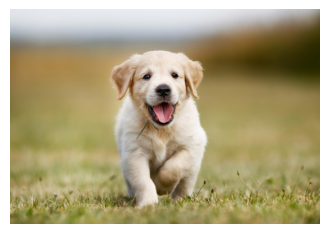

In [5]:
show_img(img)

In [6]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 216, 32400)

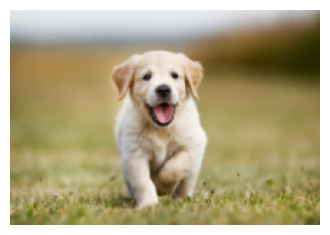

In [7]:
show_img(img2)

# PYTHON

In [9]:
def rgb2grey_py(x):
  c,h,w = x.shape
  n = h*w
  x = x.flatten() # [All red, All green, All Blue] for each pixel
  result = torch.empty(n, dtype=x.dtype, device=x.device)
  for i in range(n):
    result[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

  return result.view(h,w)

In [11]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 1.24 s, sys: 2.88 ms, total: 1.24 s
Wall time: 1.24 s


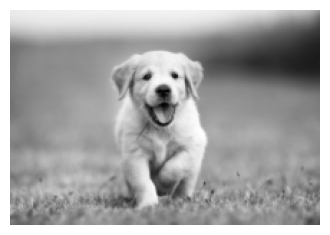

In [12]:
show_img(img_g, cmap='gray')

# Using Kernel Paradigm in Python

In [13]:
def run_kernel(f, threads, *args):
  for i in range(threads):
    f(i, *args)

In [15]:
def rgb2grey_kernel_fn(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [18]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_kernel_fn, h*w, x, res, n)
    return res.view(h,w)

CPU times: user 1.27 s, sys: 950 µs, total: 1.27 s
Wall time: 1.27 s


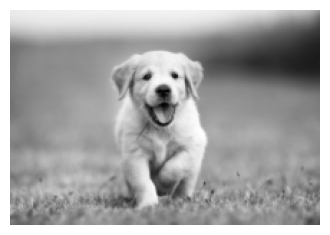

In [19]:
%%time
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

# Using Blocks Paradigm of GPUs


In [20]:
def blk_kernel(f, blocks, threads, *args):
  for i in range(blocks):
    for j in range(threads):
      f(i,j,threads,*args)

In [21]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
  i = blockidx*blockdim + threadidx
  if i<n:
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [22]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

CPU times: user 1.59 s, sys: 3.24 ms, total: 1.6 s
Wall time: 1.65 s


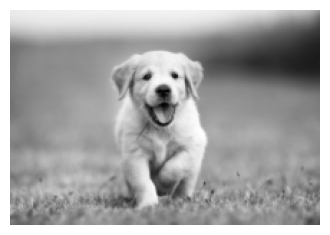

In [23]:
%%time
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

# Using CUDA

In [24]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [26]:
%pip install -q wurlitzer ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 2.3 MB/s eta 0:00:00


In [27]:
%load_ext wurlitzer

In [28]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
  return load_inline(
      cuda_sources=[cuda_src],
      cpp_sources=[cpp_src],
      functions=funcs,
      extra_cuda_cflags=["-02"] if opt else [],
      verbose=verbose,
      name="inline_ext"
  )

In [29]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''


In [34]:
cuda_src = cuda_begin + r'''

__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n){
  int i = blockIdx.x*blockDim.x + threadIdx.x;
  if (i<n){
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
  }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input){
  CHECK_INPUT(input)
  int h = input.size(1);
  int w = input.size(2);
  printf("h*w %d*%d\n", h, w);
  auto output = torch::empty({h,w}, input.options());
  int threads = 256;
  rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(),
        output.data_ptr<unsigned char>(),
        w*h);
         C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [35]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [36]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 1 and re-building as inline_ext_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/i

Loading extension module inline_ext_v1...


In [37]:
[o for o in dir(module) if o[0]!='_']

['rgb_to_grayscale']

In [38]:
imgc = img.contiguous().cuda()

In [39]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 3.29 ms, sys: 0 ns, total: 3.29 ms
Wall time: 3.53 ms


(1330, 1920, 2553600)

h*w 1330*1920


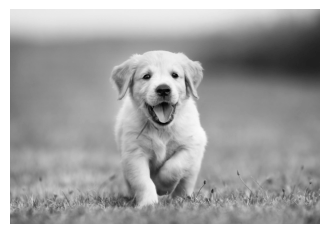

In [40]:
show_img(res, cmap='gray')

In [77]:
height = img2.shape[1]
width = img2.shape[2]
green = img2[2,:,:].cuda()
blue = img2[1,:,:].cuda()
red = img2[0,:,:].cuda()
gray = torch.empty((height, width), dtype=torch.uint8, device='cuda')

In [55]:
red_ptr = red.contiguous().data_ptr()
green_ptr = green.contiguous().data_ptr()
blue_ptr = blue.contiguous().data_ptr()

In [69]:
source_code = r"""
#include <torch/extension.h>
#include <cuda.h>
#include <cuda_runtime.h>

__global__ void rgb2gray_kernel(unsigned char* red, unsigned char* green, unsigned char* blue, unsigned char* gray, unsigned int width, unsigned int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x < width && y < height) {
        int idx = y * width + x;
        gray[idx] = 0.299f * red[idx] + 0.587f * green[idx] + 0.114f * blue[idx];
    }
}

void rgb2gray_gpu(torch::Tensor red, torch::Tensor green, torch::Tensor blue, torch::Tensor gray, unsigned int width, unsigned int height) {
    unsigned char *red_d = red.data_ptr<unsigned char>();
    unsigned char *green_d = green.data_ptr<unsigned char>();
    unsigned char *blue_d = blue.data_ptr<unsigned char>();
    unsigned char *gray_d = gray.data_ptr<unsigned char>();

    dim3 numThreadsPerBlock(32, 32);
    dim3 numBlocks((width + numThreadsPerBlock.x - 1) / numThreadsPerBlock.x, (height + numThreadsPerBlock.y - 1) / numThreadsPerBlock.y);
    rgb2gray_kernel<<<numBlocks, numThreadsPerBlock>>>(red_d, green_d, blue_d, gray_d, width, height);
    cudaDeviceSynchronize();
}
"""

cpp_src = "void rgb2gray_gpu(at::Tensor red, at::Tensor green, at::Tensor blue, at::Tensor gray, unsigned int width, unsigned int height);"


In [70]:
module = load_cuda(source_code, cpp_src, ['rgb2gray_gpu'], verbose=True)

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 5 and re-building as inline_ext_v5...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v5...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v5 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v5 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/i

Loading extension module inline_ext_v5...


In [78]:
%%time
module.rgb2gray_gpu(red, green, blue, gray, height, width)

CPU times: user 146 µs, sys: 12 µs, total: 158 µs
Wall time: 165 µs


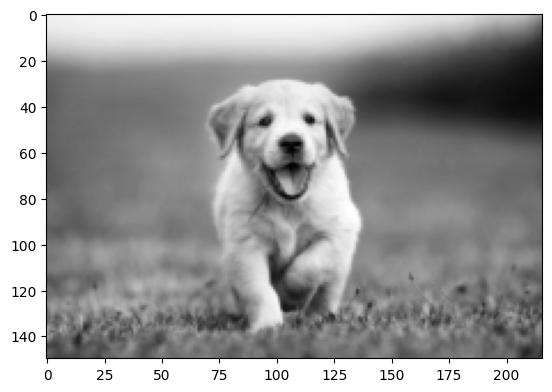

In [85]:
plt.imshow(gray.cpu(), cmap='gray')